# Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import divexplorer 
import pandas as pd
pd.set_option('max_colwidth', None)
import os
import numpy as np

from utils_analysis import filter_itemset_df_by_attributes, slice_by_itemset, plotShapleyValue,\
    plot_true_pred, plotComparisonShapleyValues, plotMultipleSV, plotMultipleSV_4

import warnings
warnings.filterwarnings("ignore")

In [3]:
## Define the minimum support threshold for data subgroups
min_sup = 0.03

# Util Functions

In [4]:
## Function for sorting data cohorts
def sortItemset(x, abbreviations={}):
    x = list(x)
    x.sort()
    x = ", ".join(x)
    for k, v in abbreviations.items():
        x = x.replace(k, v)
    return x

In [5]:
def attributes_in_itemset(itemset, attributes, alls = True):
    """ Check if attributes are in the itemset (all or at least one)
    
    Args:
        itemset (frozenset): the itemset
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        
    """
    # Avoid returning the empty itemset (i.e., info of entire dataset)
    if itemset == frozenset() and attributes:
        return False
    
    for item in itemset:
        # Get the attribute
        attr_i = item.split("=")[0]
        
        #If True, check if ALL attributes of the itemset are the input attributes.
        if alls:
            # Check if the attribute is present. If not, the itemset is not admitted
            if attr_i not in attributes:
                return False
        else:
            # Check if least one attribute. If yes, return True
            if attr_i in attributes:
                return True
    if alls:
        # All attributes of the itemset are indeed admitted
        return True
    else:
        # Otherwise, it means that we find None
        return False
    
def filter_itemset_df_by_attributes(df: pd.DataFrame, attributes: list, alls = True, itemset_col_name: str = "itemsets") -> pd.DataFrame:
    """Get the set of itemsets that have the attributes in the input list (all or at least one)
    
    Args:
        df (pd.DataFrame): the input itemsets (with their info). 
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        itemset_col_name (str) : the name of the itemset column, "itemsets" as default
        
    Returns:
        pd.DataFrame: the set of itemsets (with their info)
    """

    return df.loc[df[itemset_col_name].apply(lambda x: attributes_in_itemset(x, attributes, alls = alls))]

In [6]:
## Function for substituting gender of a given itemset
substitute_gender = lambda x : "gender=M" if "gender=F" in x else ("gender=F" if "gender=M" in x else x)

In [7]:
n = 3  # Number of subgroups to visualize
K = 25  # Global Shapley values to visualize

In [8]:
## Define abbreviations for plot and visualization
from divexplorer.FP_Divergence import abbreviateDict
abbreviations = {'total_silence':'tot_silence', \
                  'trimmed':'trim', \
                  'total_':'', \
                  'speed_rate_word':'speakRate', \
                  'speed_rate_char':'speakCharRate', \
                  'duration': 'dur'}

abbreviations_shorter = abbreviations.copy()

# Define targets

In [9]:
## Target for DivExplorer: 
# 'prediction' is 1 if predicted_intet == original_intent, 0 otherwise
target_col = 'prediction' 
target_metric = 'd_posr'
target_div = 'd_accuracy'
t_value_col = 't_value_tp_fn'

In [10]:
## Columns for visualization
show_cols = ['support', 'itemsets', '#errors', '#corrects', 'accuracy', \
                'd_accuracy', 't_value', 'support_count', 'length']
remapped_cols = {'tn': '#errors', 'tp': '#corrects', 'posr': 'accuracy', \
                target_metric: target_div, 't_value_tp_fn': 't_value'}

In [11]:
## Columns of the df file that we are going to analyze 
demo_cols = ['gender']

slot_cols = ['label']

signal_cols = ['total_silence', 'total_duration', 'trimmed_duration', 
       'n_words', 'speed_rate_word', 'speed_rate_word_trimmed',
       'valence', 'activation', 'dominance'] 

input_cols = demo_cols + slot_cols + signal_cols 

# Retrieve Data and Compute Divergence

In [12]:
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer
from divexplorer.FP_Divergence import FP_Divergence

In [13]:
configs = ["wav2vec2-base", "wav2vec2-large", "hubert-base", "hubert-large"]

FP_fm_dict = {}
fp_divergence_dict = {}
df_dict = {}

for config in configs:

    print(config)

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "IEMOCAP", f"IEMOCAP_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0)
    df[target_col] = df[target_col]

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )

    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)
    
    ## Create dict of Divergence df
    df_dict[config] = df_discretized

    fp_diver = FP_DivergenceExplorer(df_discretized, true_class_name = target_col, class_map={"P":1, "N":0})
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])

    FP_fm.rename(columns = remapped_cols, inplace = True)
    FP_fm = FP_fm[show_cols].copy()
    FP_fm['accuracy'] = round(FP_fm['accuracy'], 5)
    FP_fm['d_accuracy'] = round(FP_fm['d_accuracy'], 5)
    FP_fm['t_value'] = round(FP_fm['t_value'], 2)
    FP_fm_dict[config] = FP_fm
    fp_divergence_dict[config] = FP_Divergence(FP_fm, target_div)

wav2vec2-base


wav2vec2-large
hubert-base
hubert-large


In [14]:
## Check the accuracy of the models
for config in configs:
    prediction = df_dict[config]['prediction'].sum()/len(df_dict[config])
    print(f"Accuracy of {config}:", round(100*prediction,3))
    print("----------")

Accuracy of wav2vec2-base: 74.655
----------
Accuracy of wav2vec2-large: 71.18
----------
Accuracy of hubert-base: 67.439
----------
Accuracy of hubert-large: 74.989
----------


In [15]:
W2V2_BASE_ACC = 74.655
W2V2_LARGE_ACC = 71.18
HUB_BASE_ACC = 67.439
HUB_LARGE_ACC = 74.989

In [16]:
## Check the accuracy of the models, separately per gender
for config in configs:
    print(config)
    print(filter_itemset_df_by_attributes(FP_fm_dict[config],['gender'], alls = True)\
        [['itemsets', 'accuracy', 'd_accuracy', 't_value']]\
        .sort_values('d_accuracy', ascending = False))
    print("----------")

wav2vec2-base
     itemsets  accuracy  d_accuracy  t_value
1  (gender=M)   0.76253     0.01599     1.44
2  (gender=F)   0.73014    -0.01640     1.44
----------
wav2vec2-large
     itemsets  accuracy  d_accuracy  t_value
1  (gender=M)   0.72647     0.01467     1.26
2  (gender=F)   0.69675    -0.01505     1.28
----------
hubert-base
     itemsets  accuracy  d_accuracy  t_value
1  (gender=M)   0.68690     0.01251     1.04
2  (gender=F)   0.66155    -0.01284     1.05
----------
hubert-large
     itemsets  accuracy  d_accuracy  t_value
1  (gender=M)   0.76429     0.01440     1.30
2  (gender=F)   0.73511    -0.01478     1.31
----------


In [17]:
## Test Samples
config = 'wav2vec2-base'
print("Test Samples: ", len(df_dict[config]))
print("Subgroup Explored: ", len(FP_fm_dict[config]))

Test Samples:  4490
Subgroup Explored:  7932


In [18]:
import time
from tqdm import tqdm

## Compute time for the DivExplorer algorithm
overall_time = []

for i in tqdm(range(10)):

    config = 'wav2vec2-base'

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "IEMOCAP", f"IEMOCAP_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0)
    df[target_col] = df[target_col]

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )

    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)

    start_time = time.time()
    fp_diver = FP_DivergenceExplorer(df_discretized, true_class_name = target_col, class_map={"P":1, "N":0})
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])
    # print("--- %s seconds ---" % (time.time() - start_time))
    overall_time.append(time.time() - start_time)

print("Average time: ", np.mean(overall_time))
print("Worst time: ", np.max(overall_time))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]

Average time:  1.1539687395095826
Worst time:  1.3048865795135498


# Divergence Wav2Vec2-Base

In [19]:
## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]

In [20]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
6289,"activation=low, label=hap",0.03,44.737,-29.918,7.37
7082,"activation=low, label=hap, valence=high",0.03,46.154,-28.501,6.81
4061,"label=hap, tot_silence=low",0.04,48.947,-25.707,7.02


In [21]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
7375,"label=sad, tot_silence=low, trim_dur=high, valence=low",0.03,98.571,23.917,17.01
7736,"gender=M, label=sad, tot_silence=low, trim_dur=high",0.03,98.529,23.875,16.60
7931,"activation=low, label=sad, dur=high, tot_silence=low",0.03,98.519,23.864,16.49


Accuracy,  98.571
Δ_Acc:  23.915999999999997
Support:  0.031 %


/home/akoudounas/miniconda3/envs/speech/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


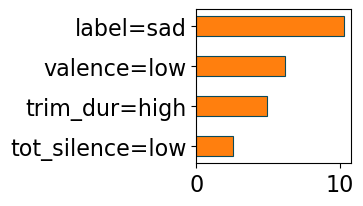

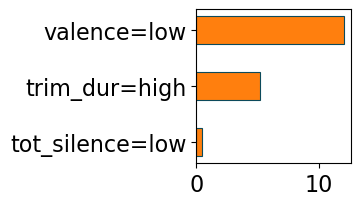

In [22]:
## Subgroup: {'label=sad', 'valence=low', 'tot_silence=low', 'trim_dur=high'}
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_pi = FPdiv.copy()

positive_itemset = frozenset({'label=sad', 'valence=low', 'total_silence=low', 'trimmed_duration=high'})
acc = pr_pi[pr_pi['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy, ", acc)
print("Δ_Acc: ", acc - W2V2_BASE_ACC)
print("Support: ", round(pr_pi[pr_pi['itemsets'] == positive_itemset].support.values[0], 3), "%")

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=False,
                saveFig=True, nameFig='plot_results/IEMOCAP/w2v2b_most_positive.pdf')

## Subgroup: {'valence=low', 'tot_silence=low', 'trim_dur=high'}
positive_itemset = frozenset({'valence=low', 'total_silence=low', 'trimmed_duration=high'})
itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

Accuracy,  44.737
Δ_Acc:  -29.918
Support:  0.034 %


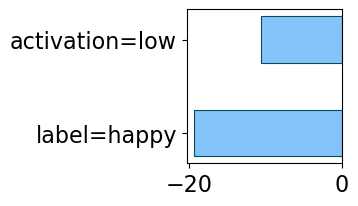

Accuracy,  64.034
Δ_Acc:  -10.620999999999995
Support:  0.133 %


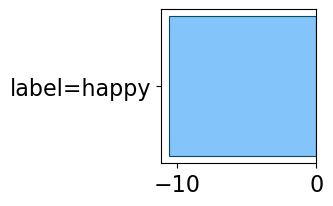

In [23]:
## Subgroup: {'label=hap', 'activation=low'}
negative_itemset = frozenset({'label=hap', 'activation=low'})
acc = pr_pi[pr_pi['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy, ", acc)
print("Δ_Acc: ", acc - W2V2_BASE_ACC)
print("Support: ", round(pr_pi[pr_pi['itemsets'] == negative_itemset].support.values[0], 3), "%")

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
new_itemset_shap = {}
for k,v in itemset_shap.items():
    if k == frozenset({'label=hap'}):
        new_itemset_shap[frozenset({'label=happy'})] = v
    else:
        new_itemset_shap[k] = v
plotShapleyValue(shapley_values=abbreviateDict(new_itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True,
                saveFig=True, nameFig='plot_results/IEMOCAP/w2v2b_most_negative.pdf')

## Subgroup: {'label=hap'}
negative_itemset = frozenset({'label=hap'})
acc = pr_pi[pr_pi['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy, ", acc)
print("Δ_Acc: ", acc - W2V2_BASE_ACC)
print("Support: ", round(pr_pi[pr_pi['itemsets'] == negative_itemset].support.values[0], 3), "%")

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
new_itemset_shap = {}
for k,v in itemset_shap.items():
    if k == frozenset({'label=hap'}):
        new_itemset_shap[frozenset({'label=happy'})] = v
    else:
        new_itemset_shap[k] = v
plotShapleyValue(shapley_values=abbreviateDict(new_itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

Accuracy:  87.407
Δ_Acc:  12.752


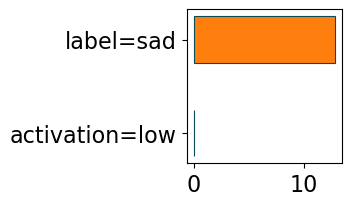

In [24]:
## Subgroup: {'label=sad', 'activation=low'}
positive_itemset = frozenset({'label=sad', 'activation=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_pi = FPdiv.copy()
acc = pr_pi[pr_pi['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy: ", round(acc,3))
print("Δ_Acc: ", round(acc - W2V2_BASE_ACC,3))
# print("Support: ", round(pr[pr['itemsets'] == positive_itemset].iloc[0]['support'],3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=False,
                saveFig=True, nameFig='plot_results/IEMOCAP/w2v2b_most_negative_sad.pdf')

Accuracy,  67.284
Δ_Acc:  -7.370999999999995


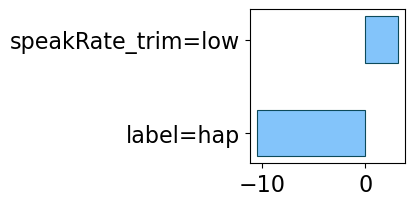

Accuracy,  70.548
Δ_Acc:  -4.106999999999999


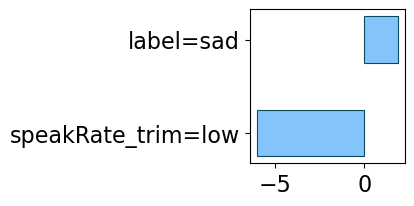

In [25]:
## Subgroup: {'label=hap', 'speakRate_trim=low'}
negative_itemset = frozenset({'label=hap', 'speed_rate_word_trimmed=low'})
acc = pr_pi[pr_pi['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy, ", acc)
print("Δ_Acc: ", acc - W2V2_BASE_ACC)

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Subgroup: {'label=sad', 'speakRate_trim=low'}
negative_itemset = frozenset({'label=sad', 'speed_rate_word_trimmed=low'})
acc = pr_pi[pr_pi['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy, ", acc)
print("Δ_Acc: ", acc - W2V2_BASE_ACC)

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

Individual Divergence


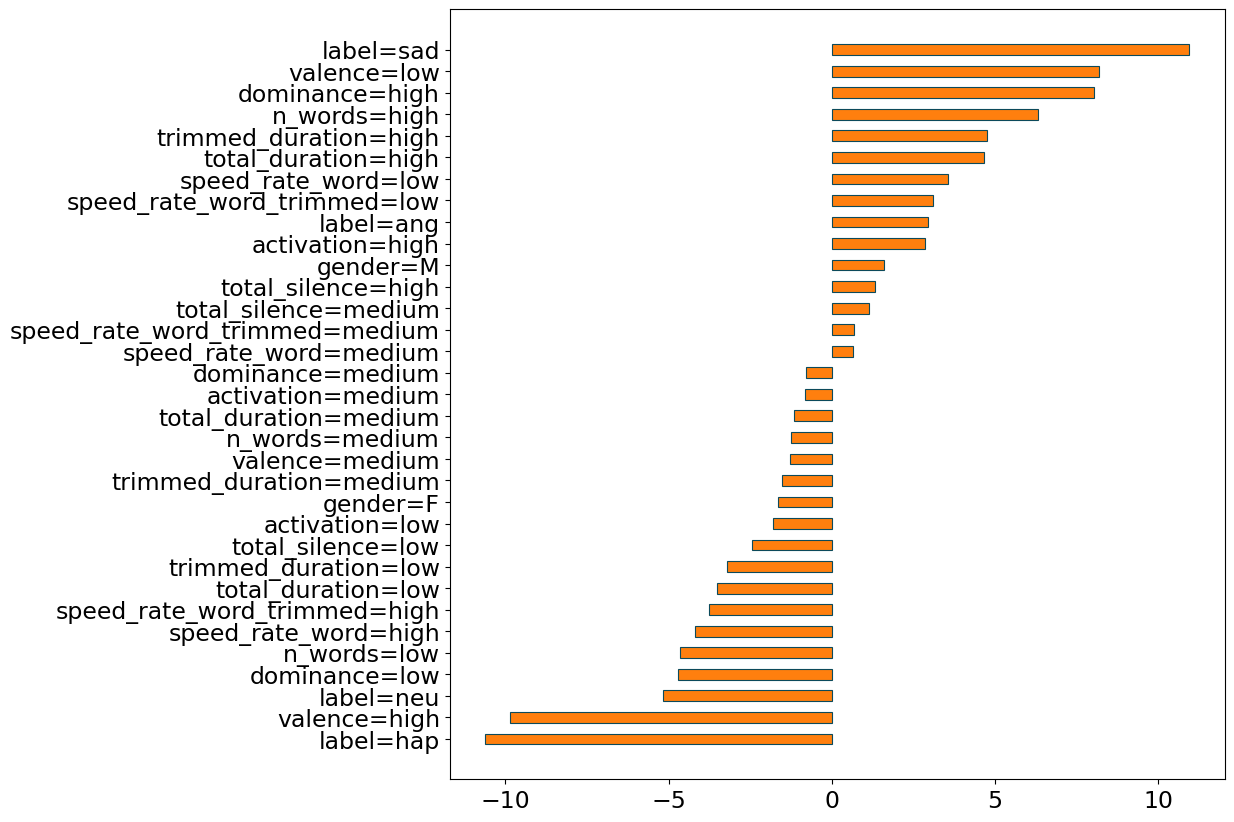

------------------------

Global Divergence


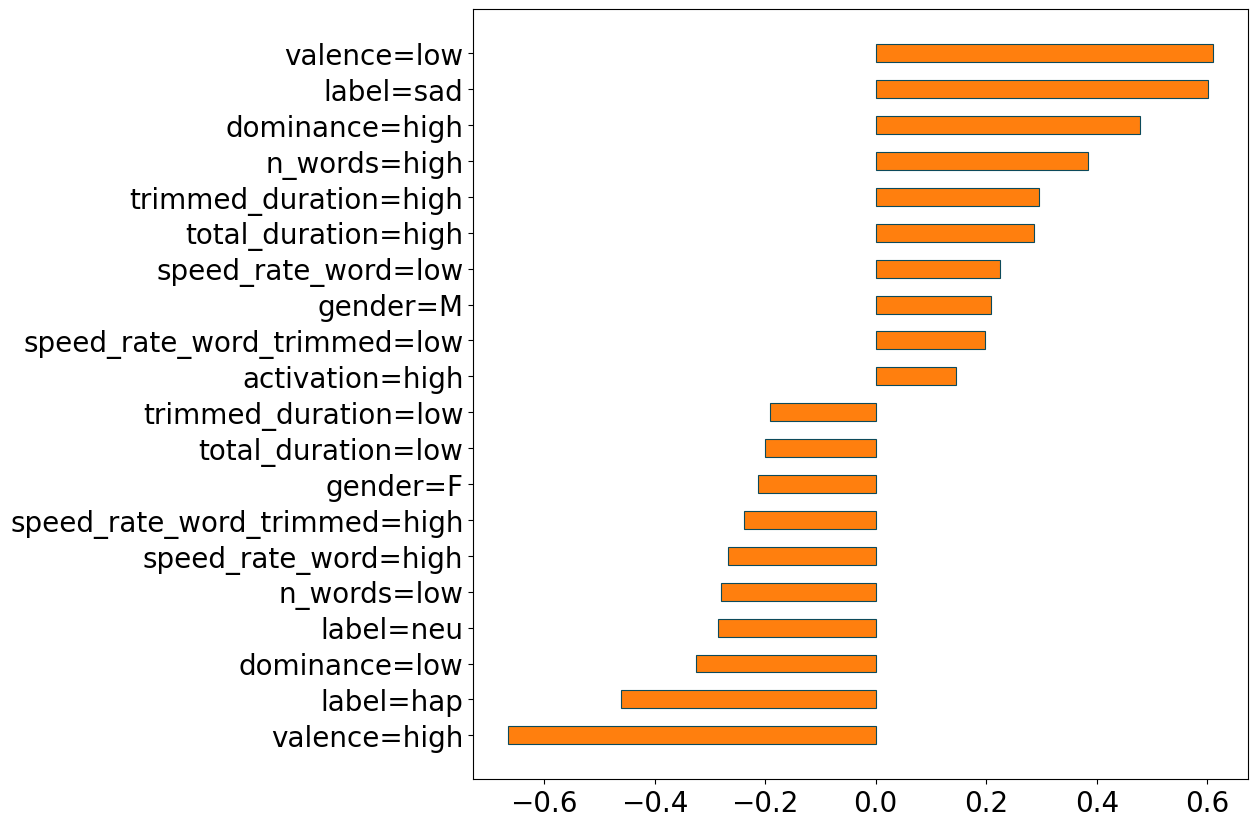

In [26]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)
print("------------------------\n")

print("Global Divergence")
global_item_divergence_wav2b = fp_divergence_i.computeGlobalShapleyValue()

K = 20
topK_global_wavb = {k:v*100 for k,v in global_item_divergence_wav2b.items() 
                if k in sorted(global_item_divergence_wav2b, 
                key=lambda x: abs(global_item_divergence_wav2b[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_wavb, 
                sizeFig=(10,10), labelsize=20, titlesize=20,
                saveFig=True, nameFig='plot_results/IEMOCAP/w2v2b_global_divergence.pdf')

# Divergence Wav2Vec2-Large

In [27]:
## Compute the divergence for Wav2Vec2-Large (300m)
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]

In [28]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
4489,"label=hap, tot_silence=low, valence=high",0.04,41.436,-29.744,8.02
4061,"label=hap, tot_silence=low",0.04,41.579,-29.601,8.17
6289,"activation=low, label=hap",0.03,44.079,-27.101,6.68


In [29]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
7375,"label=sad, tot_silence=low, trim_dur=high, valence=low",0.03,96.429,25.248,13.57
7513,"activation=low, gender=M, label=sad, trim_dur=high",0.03,94.964,23.784,11.26
7736,"gender=M, label=sad, tot_silence=low, trim_dur=high",0.03,94.853,23.673,11.00


Accuracy,  80.247
Δ_Acc:  9.066999999999993


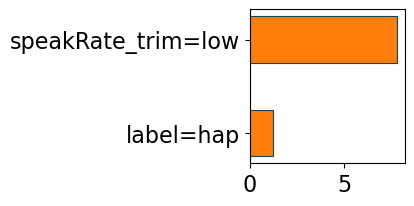

Accuracy,  50.685
Δ_Acc:  -20.495000000000005


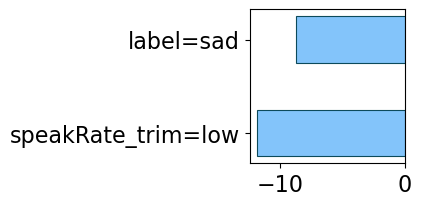

In [30]:
## Subgroup: {'label=hap', 'speakRate_trim=low'}
positive_itemset = frozenset({'label=hap', 'speed_rate_word_trimmed=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
acc = pr_ni[pr_ni['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy, ", acc)
print("Δ_Acc: ", acc - W2V2_LARGE_ACC)

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Subgroup: {'label=sad', 'speakRate_trim=low'}
negative_itemset = frozenset({'label=sad', 'speed_rate_word_trimmed=low'})
acc = pr_ni[pr_ni['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy, ", acc)
print("Δ_Acc: ", acc - W2V2_LARGE_ACC)

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

Individual Divergence


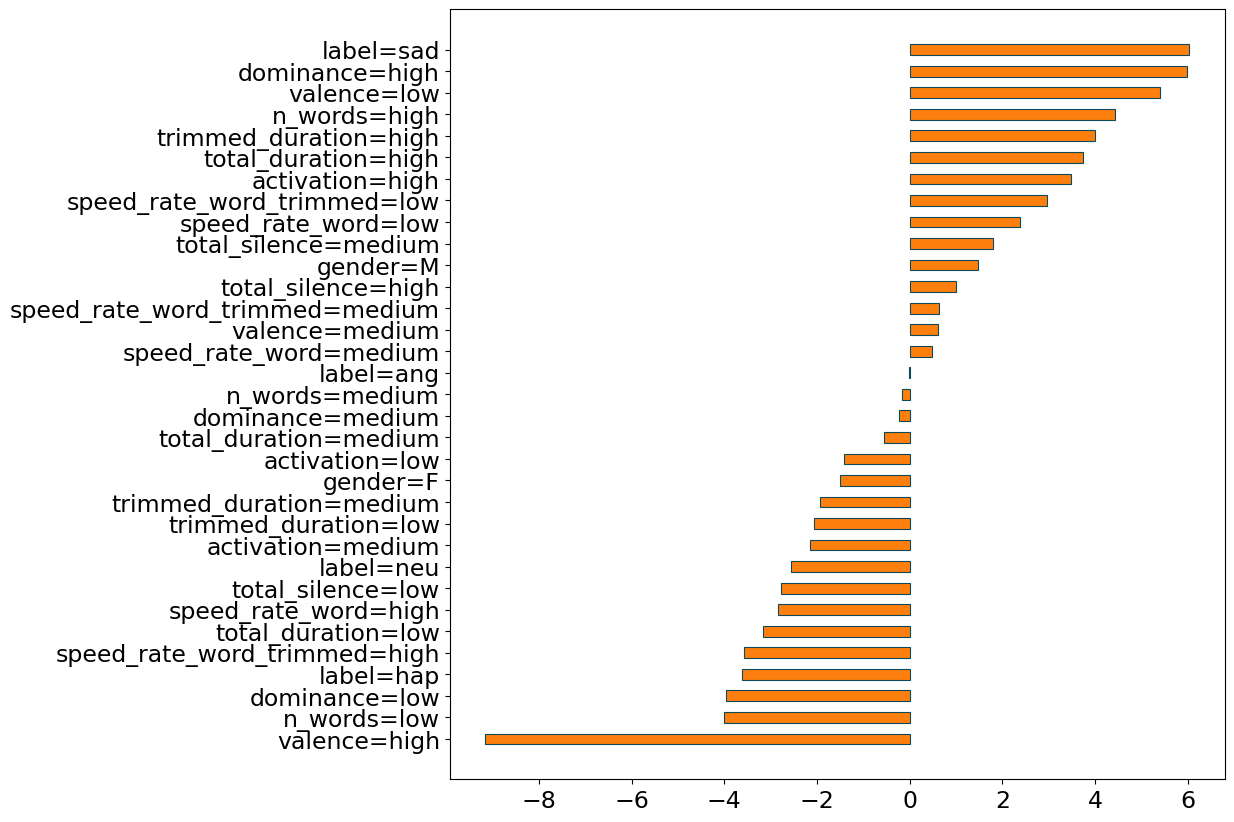

------------------------

Global Divergence


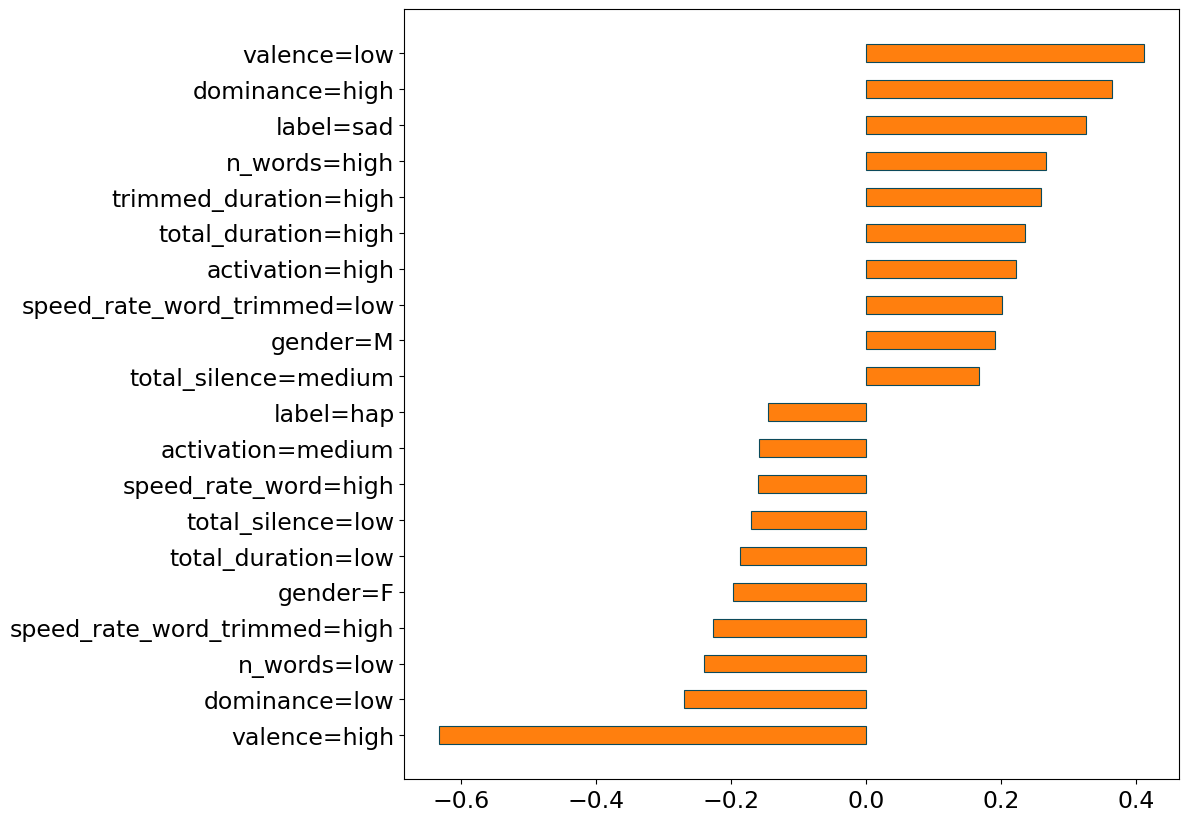

In [31]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)
print("------------------------\n")

print("Global Divergence")
global_item_divergence_wav2l = fp_divergence_i.computeGlobalShapleyValue()

topK_global_wavl = {k:v*100 for k,v in global_item_divergence_wav2l.items() 
                    if k in sorted(global_item_divergence_wav2l, 
                    key=lambda x: abs(global_item_divergence_wav2l[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_wavl, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

# Divergence HuBERT-Base

In [32]:
## Compute the divergence for HuBERT base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]

In [33]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
4061,"label=hap, tot_silence=low",0.04,25.263,-42.176,13.04
4489,"label=hap, tot_silence=low, valence=high",0.04,25.414,-42.024,12.67
7082,"activation=low, label=hap, valence=high",0.03,26.573,-40.865,10.85


Accuracy,  25.263
Δ_Acc:  -42.176
Support:  0.042


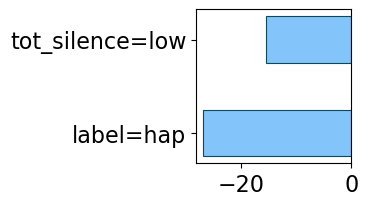

Accuracy,  87.351
Δ_Acc:  19.912
Support:  0.15


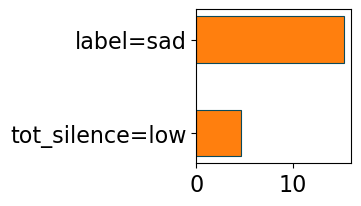

In [34]:
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()

## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    acc = pr_ni[pr_ni['itemsets'] == itemset_1].accuracy.values[0]*100
    print("Accuracy, ", round(acc,3))
    print("Δ_Acc: ", round(acc - HUB_BASE_ACC,3)) 
    print("Support: ", round(pr_ni[pr_ni['itemsets'] == itemset_1].iloc[0]['support'],3))  
    itemset_shap = fp_divergence_i.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    name_fig = f"plot_results/IEMOCAP/local_shapley_hb_1.pdf"
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                    sizeFig=(2,2), labelsize=16, titlesize=16, \
                    nameFig=name_fig, saveFig=False, negative=True)

## Subgroup: {'label=sad', 'tot_silence=low'}
positive_itemset = frozenset({'label=sad', 'total_silence=low'})
acc = pr_ni[pr_ni['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy, ", round(acc,3))
print("Δ_Acc: ", round(acc - HUB_BASE_ACC,3))
print("Support: ", round(pr_ni[pr_ni['itemsets'] == positive_itemset].iloc[0]['support'],3))  
itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
name_fig = "plot_results/IEMOCAP/local_shapley_hb_2.pdf"
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, \
                nameFig=name_fig, saveFig=False)

Accuracy,  64.034
Δ_Acc:  -3.405


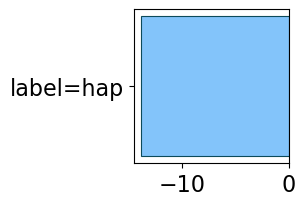

In [35]:
## Subgroup: {'label=hap'}
negative_itemset = frozenset({'label=hap'})
acc = pr_pi[pr_pi['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy, ", acc)
print("Δ_Acc: ", round(acc - HUB_BASE_ACC,3))
itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

In [36]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
5244,"activation=low, label=sad, tot_silence=low, trim_dur=high",0.04,99.401,31.962,28.93
7248,"label=sad, speakRate_trim=high, tot_silence=low, trim_dur=high",0.03,98.582,31.143,22.02
7736,"gender=M, label=sad, tot_silence=low, trim_dur=high",0.03,98.529,31.091,21.39


Accuracy,  97.605
Δ_Acc:  30.166


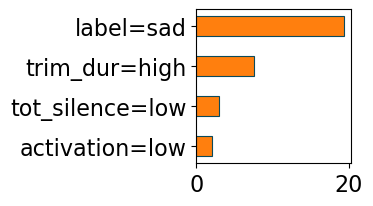

In [37]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    acc = pr_pi[pr_pi['itemsets'] == itemset_1].accuracy.values[0]*100
    print("Accuracy, ", acc)
    print("Δ_Acc: ", round(acc - HUB_BASE_ACC,3))
    itemset_shap = fp_divergence_i.computeShapleyValue(itemset_1)
    
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    name_fig = f"plot_results/IEMOCAP/local_shapley_hb_3.pdf"
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), \
            sizeFig=(2,2), labelsize=16, titlesize=16, \
            nameFig=name_fig, saveFig=False)

Accuracy,  75.325
Δ_Acc:  7.886


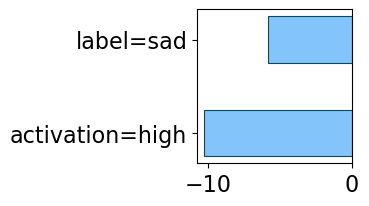

Accuracy,  75.714
Δ_Acc:  8.275


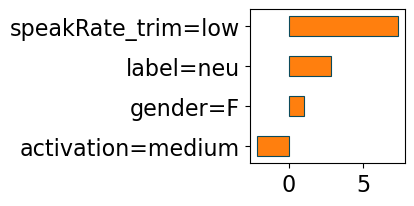

Accuracy,  65.761
Δ_Acc:  -1.678


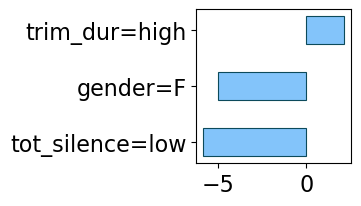

In [38]:
## Subgroup: {'label=sad', 'activation=high'}
negative_itemset = frozenset({'label=sad', 'activation=high'})
acc = pr_pi[pr_pi['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy, ", round(acc,3))
print("Δ_Acc: ", round(acc - HUB_BASE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Subgroup: {'gender=F', 'activation=medium','label=neu', 'speakRate_trim=low'}
positive_itemset = frozenset({'gender=F', 'activation=medium','label=neu', 'speed_rate_word_trimmed=low'})
acc = pr_pi[pr_pi['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy, ", round(acc,3))
print("Δ_Acc: ", round(acc - HUB_BASE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)


## gender=F and label=sad together does not exist for this support threshold
## Subgroup: {'gender=F', 'tot_silence=low','trim_dur=high'}
negative_itemset = frozenset({'gender=F', 'total_silence=low','trimmed_duration=high'})   
acc = pr_pi[pr_pi['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy, ", round(acc,3))
print("Δ_Acc: ", round(acc - HUB_BASE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

Individual Divergence


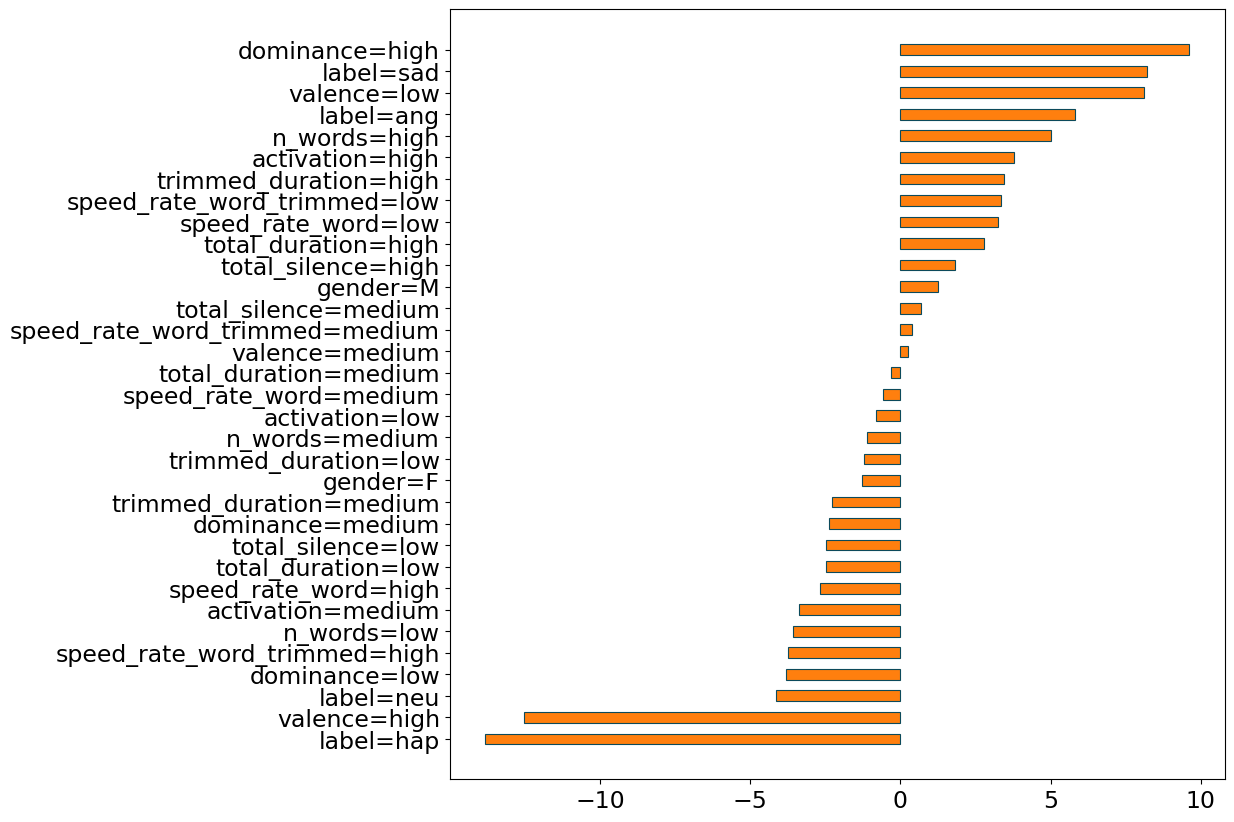

------------------------

Global Divergence


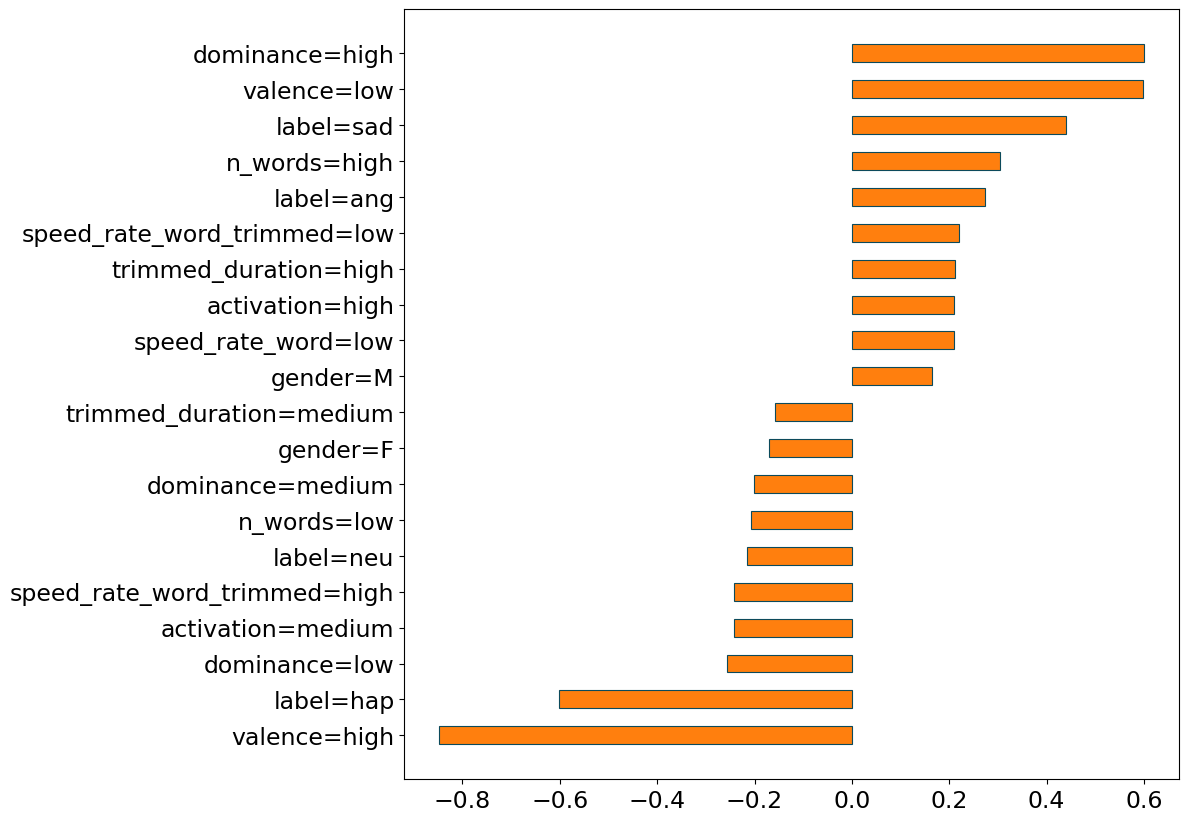

In [39]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)
print("------------------------\n")


print("Global Divergence")
global_item_divergence_hubb = fp_divergence_i.computeGlobalShapleyValue()

topK_global_hubb = {k:v*100 for k,v in global_item_divergence_hubb.items() 
                    if k in sorted(global_item_divergence_hubb, 
                    key=lambda x: abs(global_item_divergence_hubb[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_hubb, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

# Divergence HuBERT-Large

In [40]:
## Compute the divergence for HuBERT large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]

In [41]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
4061,"label=hap, tot_silence=low",0.04,42.632,-32.357,8.92
6289,"activation=low, label=hap",0.03,43.421,-31.568,7.80
4489,"label=hap, tot_silence=low, valence=high",0.04,43.646,-31.342,8.42


Accuracy,  66.723
Δ_Acc:  -8.266


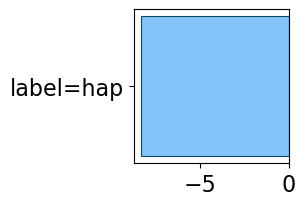

In [42]:
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr_ni = FPdiv.copy()

## Subgroup: {'label=hap'}
negative_itemset = frozenset({'label=hap'})
acc = pr_ni[pr_ni['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy, ", round(acc,3))
print("Δ_Acc: ", round(acc - HUB_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

In [43]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
7518,"activation=low, label=sad, n_words=high, trim_dur=high",0.03,97.842,22.853,14.45
7736,"gender=M, label=sad, tot_silence=low, trim_dur=high",0.03,97.794,22.805,14.16
7909,"activation=low, label=sad, n_words=high, dur=high, trim_dur=high",0.03,97.778,22.789,14.06


Accuracy,  75.325
Δ_Acc:  0.336


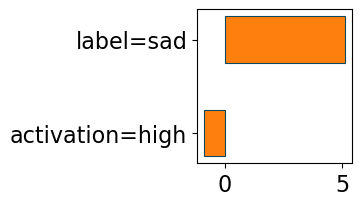

Accuracy,  70.0
Δ_Acc:  -4.989


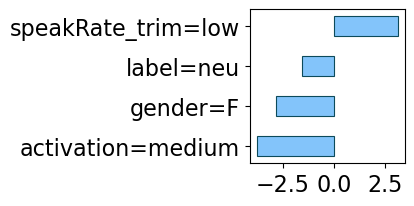

In [44]:
## Subgroup: {'label=sad', 'activation=high'}
positive_itemset = frozenset({'label=sad', 'activation=high'})
acc = pr_pi[pr_pi['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy, ", round(acc,3))
print("Δ_Acc: ", round(acc - HUB_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Subgroup: {'gender=F', 'activation=medium','label=neu', 'speakRate_trim=low'}
negative_itemset = frozenset({'gender=F', 'activation=medium','label=neu', 'speed_rate_word_trimmed=low'})
acc = pr_ni[pr_ni['itemsets'] == negative_itemset].accuracy.values[0]*100
print("Accuracy, ", round(acc,3))
print("Δ_Acc: ", round(acc - HUB_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

Individual Divergence


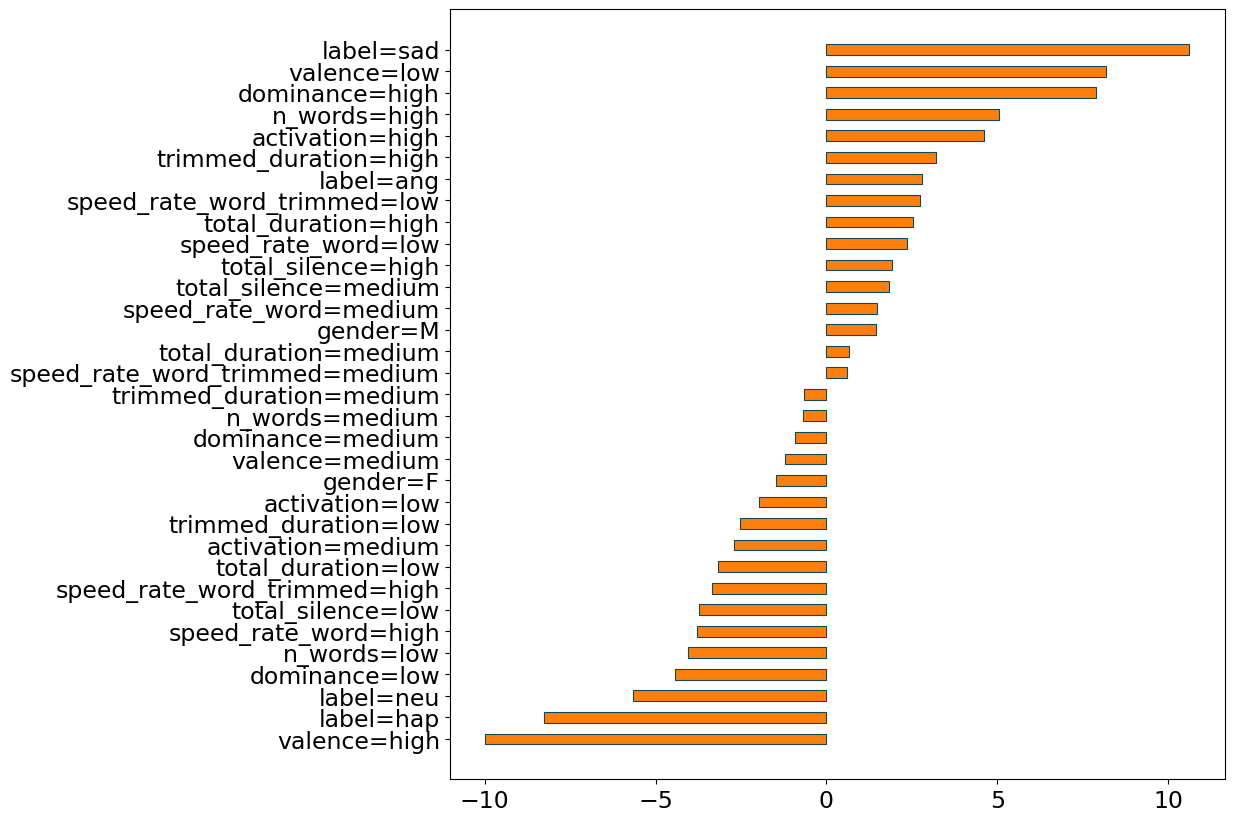

------------------------

Global Divergence


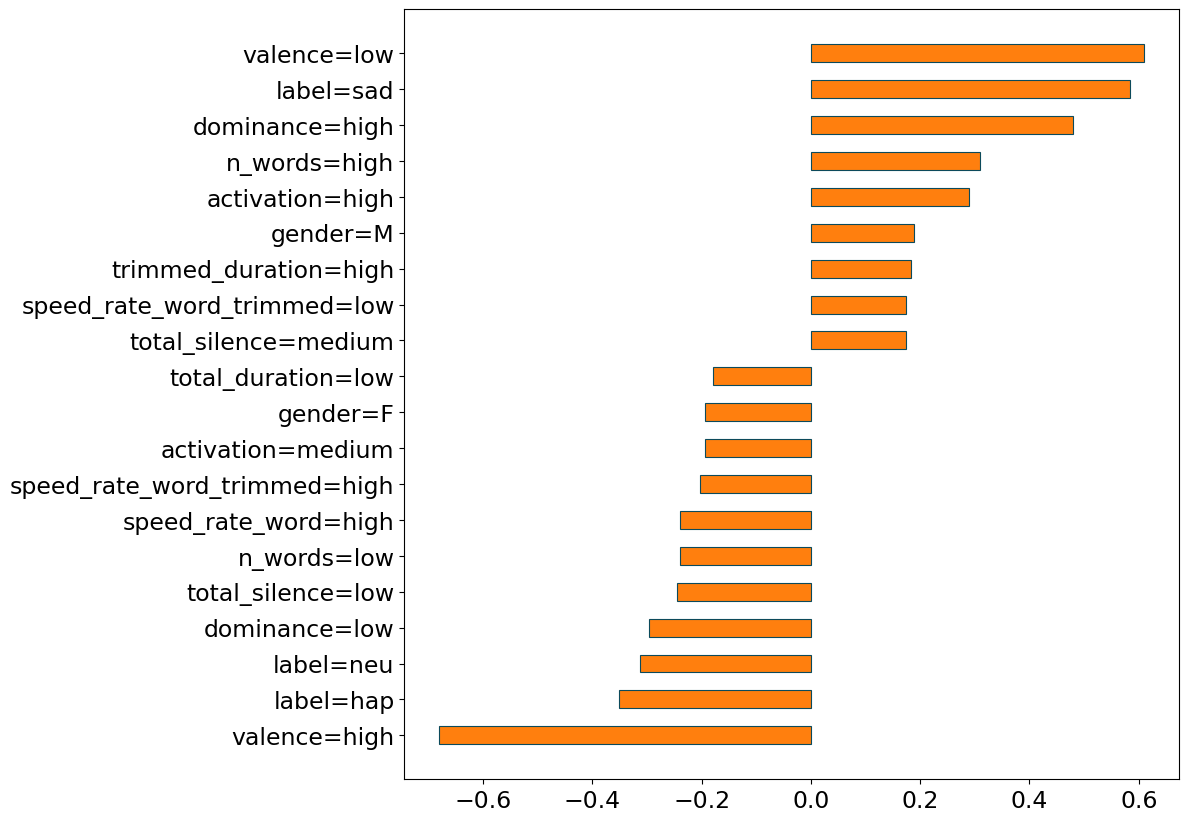

In [45]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence,
                sizeFig=(10,10), labelsize=17, titlesize=17)
print("------------------------\n")

print("Global Divergence")
global_item_divergence_hubl = fp_divergence_i.computeGlobalShapleyValue()

topK_global_hubl = {k:v*100 for k,v in global_item_divergence_hubl.items() 
                    if k in sorted(global_item_divergence_hubl, 
                    key=lambda x: abs(global_item_divergence_hubl[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_hubl, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

# Divergence difference Wav2Vec2-Base vs Wav2Vec2-Large

In [46]:
## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2l = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wlarge = FPdiv_w2l.set_index("itemsets")

## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2b = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wbase = FPdiv_w2b.set_index("itemsets")

## Merge the df
merged = wbase.join(wlarge, lsuffix='_base', rsuffix='_large')
merged = merged.rename(columns={'support_large': 'support'})

In [47]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_large"] - merged["accuracy_base"]
merged["difference"] = merged["accuracy_large"] - merged["accuracy_base"]

In [48]:
## Create "Gain Base-Large W2V2" df and compute divergence
base_large_gain_df = merged[['support', '#errors_large', '#corrects_large', 'accuracy_large',
       'd_accuracy_large', 't_value_large', 'support_count_large', 'length_large'] \
       + [diff, "difference", "accuracy_base"]]
base_large_gain_df = base_large_gain_df.rename(columns={'length_large':'length'})
base_large_gain_df = base_large_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(base_large_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [49]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_base', 'accuracy_large', 'support']

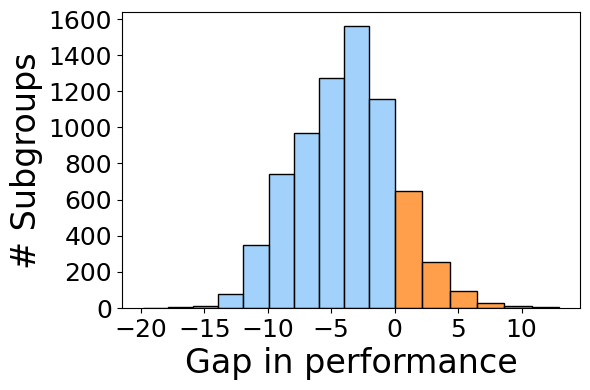

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=10, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=6, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/IEMOCAP/distribution_gain_w2v2_base_large.pdf")

## Stats

In [51]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are greater for Wav2Vec2-Large
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for Wav2Vec2-Large
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
2.9375
Greater
11.2078
Lower
85.8548


## Gain > 0

In [52]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs better than Wav2Vec2-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"label=hap, speakRate_trim=low",12.96,67.28,80.25,0.04
1,"label=hap, speakRate_trim=low, valence=high",12.50,67.76,80.26,0.03


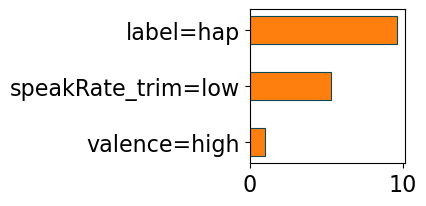

In [53]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[1].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [54]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs worse than Wav2Vec2-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"label=sad, speakRate_trim=low",-19.86,70.55,50.68,0.03
1,"label=sad, n_words=medium, dur=medium, trim_dur=medium",-16.55,84.89,68.34,0.03


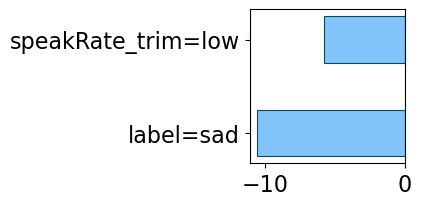

In [55]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [56]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs equal to Wav2Vec2-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("accuracy_large")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
1031,"activation=low, dominance=low, label=neu, speakRate=high, speakRate_trim=high, tot_silence=low",0.0,54.30,54.30,0.04
1030,"dominance=low, n_words=medium, valence=high",0.0,55.22,55.22,0.04


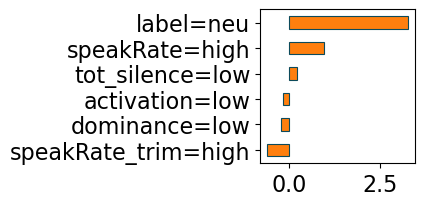

In [57]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Global Shapley value

In [58]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Base and Wav2Vec2-Large
global_item_divergence_w2b_w2l = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2b_w2l = {k:v for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(global_item_divergence_w2b_w2l, 
                        key=lambda x: abs(global_item_divergence_w2b_w2l[x]))[::-1][:K]}

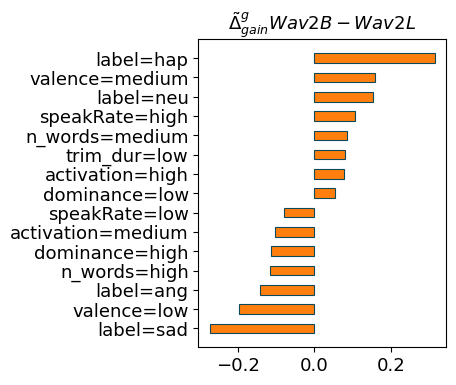

In [59]:
## Plot and Save the image 
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_w2b_w2l_abbr = abbreviateDict(topK_global_w2b_w2l, abbreviations)
topK_global_w2b_w2l_abbr = {k:v*100 for k,v in topK_global_w2b_w2l_abbr.items()}
name_fig = "plot_results/IEMOCAP/global_shapley_gain_w2b_w2l.pdf"
plotShapleyValue(shapley_values=topK_global_w2b_w2l_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} Wav2B - Wav2L$",
                nameFig=name_fig, saveFig=False)

# Divergence difference HuBERT-Base vs HuBERT-Large

In [60]:
## Compute the divergence for HuBERT-Large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hl = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hlarge = FPdiv_hl.set_index("itemsets")

## Compute the divergence for HuBERT-Base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hb = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hbase = FPdiv_hb.set_index("itemsets")

## Merge the df
merged = hbase.join(hlarge, lsuffix='_base', rsuffix='_large')
merged = merged.rename(columns={'support_large': 'support'})

In [61]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_large"] - merged["accuracy_base"]
merged["difference"] = merged["accuracy_large"] - merged["accuracy_base"]

In [62]:
## Create "Gain Base-Large HuB" df and compute divergence
base_large_gain_df = merged[['support', '#errors_large', '#corrects_large', 'accuracy_large',
       'd_accuracy_large', 't_value_large', 'support_count_large', 'length_large'] \
       + [diff, "difference", "accuracy_base"]]
base_large_gain_df = base_large_gain_df.rename(columns={'length_large':'length'})
base_large_gain_df = base_large_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(base_large_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [63]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_base', 'accuracy_large', 'support']

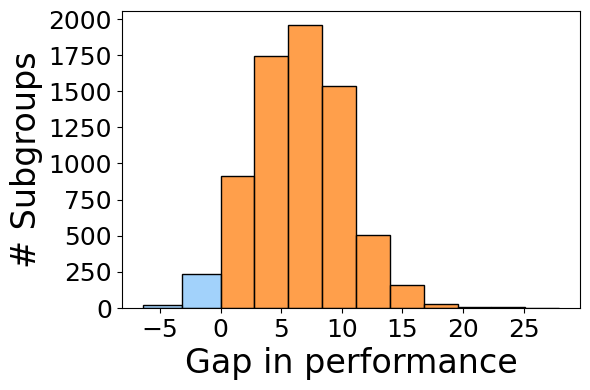

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=2, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/IEMOCAP/distribution_gain_hub_base_large.pdf")

## Stats

In [65]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are greater for HuBERT-Large
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for HuBERT-Large
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
1.5885
Greater
95.8901
Lower
2.5214


## Gain > 0

In [66]:
## Retrieve the data cohorts for which HuBERT-Large performs better than HuBERT-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"activation=high, label=sad",27.92,51.30,79.22,0.03
1,"label=sad, speakRate_trim=medium, tot_silence=high",24.38,66.25,90.62,0.04


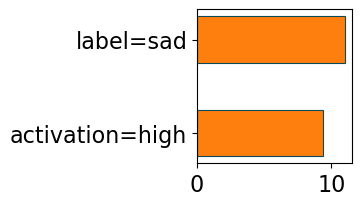

In [67]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [68]:
## Retrieve the data cohorts for which HuBERT-Large performs worse than HuBERT-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"activation=medium, gender=F, label=neu, speakRate_trim=low",-6.43,76.43,70.00,0.03
1,"activation=low, label=neu, speakRate=low, valence=medium",-5.39,87.42,82.04,0.04


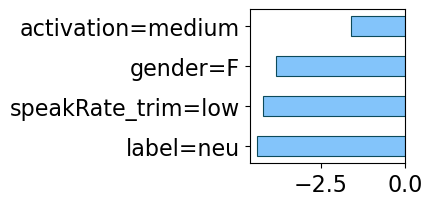

In [69]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [70]:
## Retrieve the data cohorts for which HuBERT-Large performs equal to HuBERT-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("accuracy_large")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
6856,"activation=low, gender=M, speakRate=high, dur=low, trim_dur=low",0.0,64.36,64.36,0.04
6855,"activation=low, gender=M, n_words=low, speakRate=high, trim_dur=low",0.0,65.00,65.00,0.04


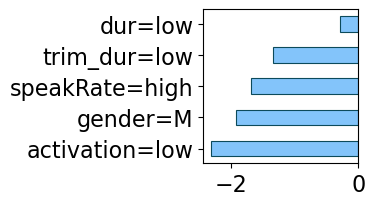

In [71]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Global Shapley value

In [72]:
## Compute the top-K global shapley values related to the gain in performance between HuBERT-Base and HuBERT-Large
global_item_divergence_hb_hl = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_hb_hl = {k:v for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(global_item_divergence_hb_hl, 
                        key=lambda x: abs(global_item_divergence_hb_hl[x]))[::-1][:K]}

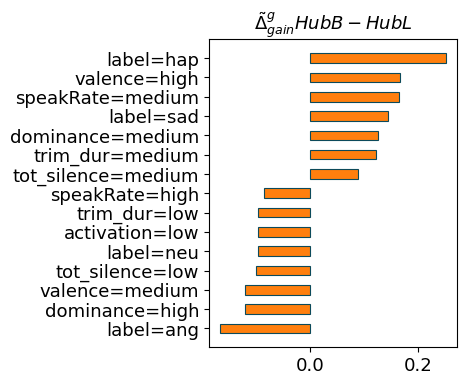

In [73]:
## Plot and Save the image 
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_hb_hl_abbr = abbreviateDict(topK_global_hb_hl, abbreviations)
topK_global_hb_hl_abbr = {k:v*100 for k,v in topK_global_hb_hl_abbr.items()}
name_fig = "plot_results/IEMOCAP/global_shapley_gain_hb_hl.pdf"
plotShapleyValue(shapley_values=topK_global_hb_hl_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} HubB - HubL$",
                nameFig=name_fig, saveFig=False)

# Divergence difference Wav2Vec-Base vs HuBERT-Base

In [74]:
## Compute the divergence for HuBERT-Base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hb = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hbase = FPdiv_hb.set_index("itemsets")

## Compute the divergence for wav2vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_wb = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wbase = FPdiv_wb.set_index("itemsets")

## Merge the df
merged = wbase.join(hbase, lsuffix='_wbase', rsuffix='_hbase')
merged = merged.rename(columns={'support_hbase': 'support'})

In [75]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_hbase"] - merged["accuracy_wbase"]
merged["difference"] = merged["accuracy_hbase"] - merged["accuracy_wbase"]

In [76]:
## Create "Gain w2v2Base-HubBase" df and compute divergence
wbase_hbase_gain_df = merged[['support', '#errors_hbase', '#corrects_hbase', 'accuracy_hbase',
       'd_accuracy_hbase', 't_value_hbase', 'support_count_hbase', 'length_hbase'] \
       + [diff, "difference", "accuracy_wbase"]]
wbase_hbase_gain_df = wbase_hbase_gain_df.rename(columns={'length_hbase':'length'})
wbase_hbase_gain_df = wbase_hbase_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(wbase_hbase_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [77]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_wbase', 'accuracy_hbase', 'support']

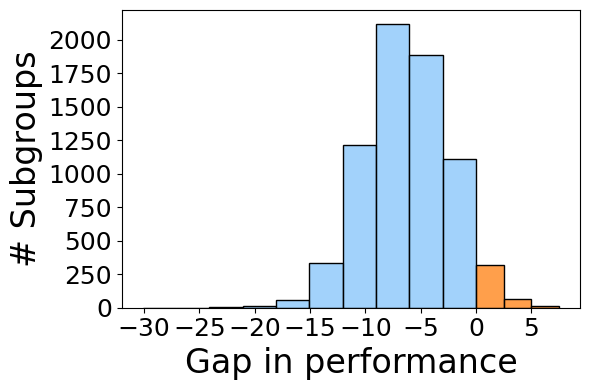

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=10, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=3, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/IEMOCAP/distribution_gain_w2v2_hub_base.pdf")

## Stats

In [79]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are greater for HuBERT-Base
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for HuBERT-Base
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
1.9037
Greater
4.1478
Lower
93.9486


## Gain > 0

In [80]:
## Retrieve the data cohorts for which HuBERT-Base performs better than Wav2Vec2-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hbase"] = (pr["accuracy_hbase"]*100).round(2)
pr["accuracy_wbase"] = (pr["accuracy_wbase"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wbase,accuracy_hbase,support
0,"activation=high, label=ang, dur=low, valence=low",7.54,75.34,82.88,0.03
1,"dominance=low, label=neu, speakRate_trim=low",7.19,68.86,76.05,0.04


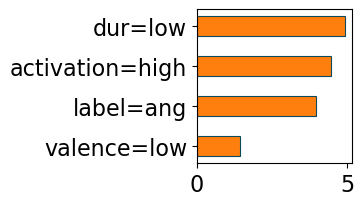

In [81]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [82]:
## Retrieve the data cohorts for which HuBERT-Base performs worse than Wav2Vec2-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hbase"] = (pr["accuracy_hbase"]*100).round(2)
pr["accuracy_wbase"] = (pr["accuracy_wbase"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wbase,accuracy_hbase,support
0,"label=sad, speakRate_trim=low",-30.14,70.55,40.41,0.03
1,"label=hap, tot_silence=low, valence=high",-24.86,50.28,25.41,0.04


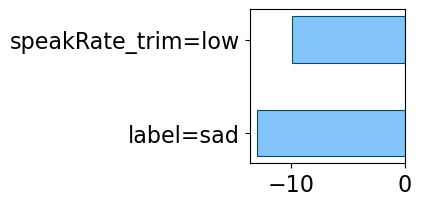

In [83]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [84]:
## Retrieve the data cohorts for which HuBERT-Base performs equal to Wav2Vec2-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hbase"] = (pr["accuracy_hbase"]*100).round(2)
pr["accuracy_wbase"] = (pr["accuracy_wbase"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("accuracy_hbase")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wbase,accuracy_hbase,support
397,"activation=low, dominance=low, label=neu, speakRate=high, speakRate_trim=high, dur=low",0.0,61.99,61.99,0.04
396,"label=neu, n_words=medium, tot_silence=high",0.0,63.23,63.23,0.03


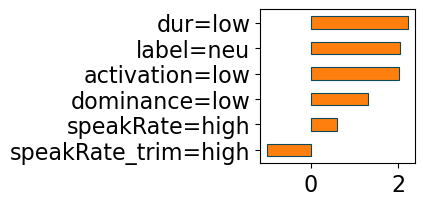

In [85]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Global Shapley value

In [86]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Base and HuBERT-Base
global_item_divergence_w2b_hb = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2b_hb = {k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(global_item_divergence_w2b_hb, 
                        key=lambda x: abs(global_item_divergence_w2b_hb[x]))[::-1][:K]}

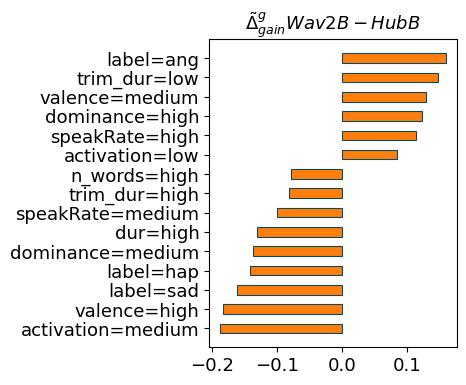

In [87]:
## Plot and Save the image 
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_w2b_hb_abbr = abbreviateDict(topK_global_w2b_hb, abbreviations)
topK_global_w2b_hb_abbr = {k:v*100 for k,v in topK_global_w2b_hb_abbr.items()}
name_fig = "plot_results/IEMOCAP/global_shapley_gain_w2b_hb.pdf"
plotShapleyValue(shapley_values=topK_global_w2b_hb_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} Wav2B - HubB$",
                nameFig=name_fig, saveFig=False)

# Divergence difference Wav2Vec-Large vs HuBERT-Large

In [88]:
## Compute the divergence for HuBERT-Large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hl = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hlarge = FPdiv_hl.set_index("itemsets")

## Compute the divergence for wav2vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_wl = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wlarge = FPdiv_wl.set_index("itemsets")

## Merge the df
merged = wlarge.join(hlarge, lsuffix='_wlarge', rsuffix='_hlarge')
merged = merged.rename(columns={'support_hlarge': 'support'})

In [89]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_hlarge"] - merged["accuracy_wlarge"]
merged["difference"] = merged["accuracy_hlarge"] - merged["accuracy_wlarge"]

In [90]:
## Create "Gain w2v2Large-HubLarge" df and compute divergence
wlarge_hlarge_gain_df = merged[['support', '#errors_hlarge', '#corrects_hlarge', 'accuracy_hlarge',
       'd_accuracy_hlarge', 't_value_hlarge', 'support_count_hlarge', 'length_hlarge'] \
       + [diff, "difference", "accuracy_wlarge"]]
wlarge_hlarge_gain_df = wlarge_hlarge_gain_df.rename(columns={'length_hlarge':'length'})
wlarge_hlarge_gain_df = wlarge_hlarge_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(wlarge_hlarge_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [91]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_wlarge', 'accuracy_hlarge', 'support']

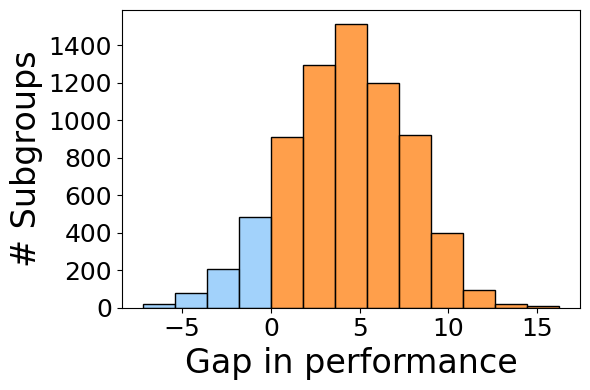

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=4, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=9, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/IEMOCAP/distribution_gain_w2v2_hub_large.pdf")

## Stats

In [93]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are greater for HuBERT-Large
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for HuBERT-Large
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
2.2693
Greater
89.1326
Lower
8.5981


## Gain > 0

In [94]:
## Retrieve the data cohorts for which HuBERT-Large performs better than Wav2Vec2-Large
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hlarge"] = (pr["accuracy_hlarge"]*100).round(2)
pr["accuracy_wlarge"] = (pr["accuracy_wlarge"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wlarge,accuracy_hlarge,support
0,"activation=high, label=sad",16.23,62.99,79.22,0.03
1,"gender=F, label=sad, tot_silence=high",15.85,68.29,84.15,0.04


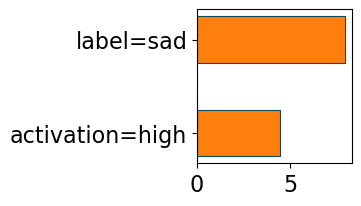

In [95]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [96]:
## Retrieve the data cohorts for which HuBERT-Large performs worse than Wav2Vec2-Large
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hlarge"] = (pr["accuracy_hlarge"]*100).round(2)
pr["accuracy_wlarge"] = (pr["accuracy_wlarge"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wlarge,accuracy_hlarge,support
0,"gender=M, label=neu, speakRate=medium, valence=medium",-7.22,78.89,71.67,0.04
1,"activation=medium, label=neu, n_words=medium, valence=medium",-6.99,80.42,73.43,0.03


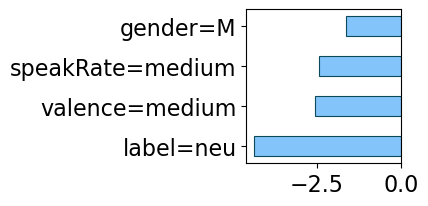

In [97]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [98]:
## Retrieve the data cohorts for which HuBERT-Large performs equal to Wav2Vec2-Large
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hlarge"] = (pr["accuracy_hlarge"]*100).round(2)
pr["accuracy_wlarge"] = (pr["accuracy_wlarge"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("accuracy_hlarge")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wlarge,accuracy_hlarge,support
6362,"gender=F, label=neu, speakRate=high, speakRate_trim=high, tot_silence=low",0.0,56.17,56.17,0.04
6361,"speakRate=high, valence=high",0.0,57.83,57.83,0.09


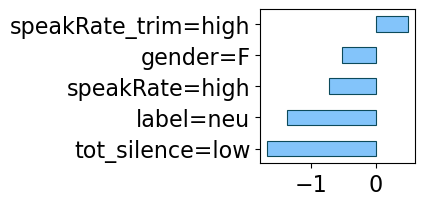

In [99]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Global Shapley value

In [100]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Large and HuBERT-Large
global_item_divergence_w2l_hl = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2l_hl = {k:v for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(global_item_divergence_w2l_hl, 
                        key=lambda x: abs(global_item_divergence_w2l_hl[x]))[::-1][:K]}

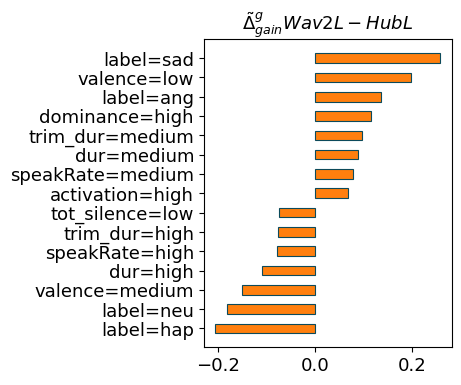

In [101]:
## Plot and Save the image 
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_w2l_hl_abbr = abbreviateDict(topK_global_w2l_hl, abbreviations)
topK_global_w2l_hl_abbr = {k:v*100 for k,v in topK_global_w2l_hl_abbr.items()}
name_fig = "plot_results/IEMOCAP/global_shapley_gain_w2l_hl.pdf"
plotShapleyValue(shapley_values=topK_global_w2l_hl_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} Wav2L - HubL$",
                nameFig=name_fig, saveFig=False)

# Global Shapley value comparison

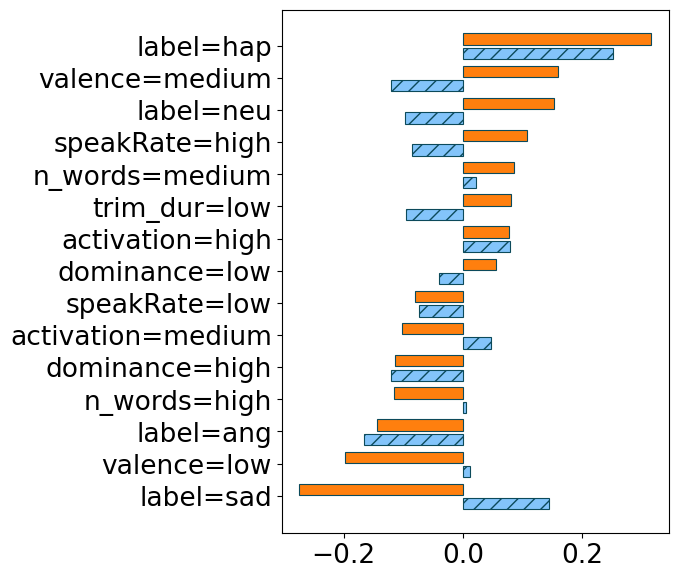

In [102]:
## Take the K Global Shapley Values for HubL-HubB starting from the top-K of WavL-WavB
topK_global_hb_hl_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)
topK_global_hb_hl_1_abbr = {k:v*100 for k,v in topK_global_hb_hl_1_abbr.items()}

name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2b_w2l_hb_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2b_w2l_hb_hl_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2b_w2l_abbr, 
            shapley_values_2=topK_global_hb_hl_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

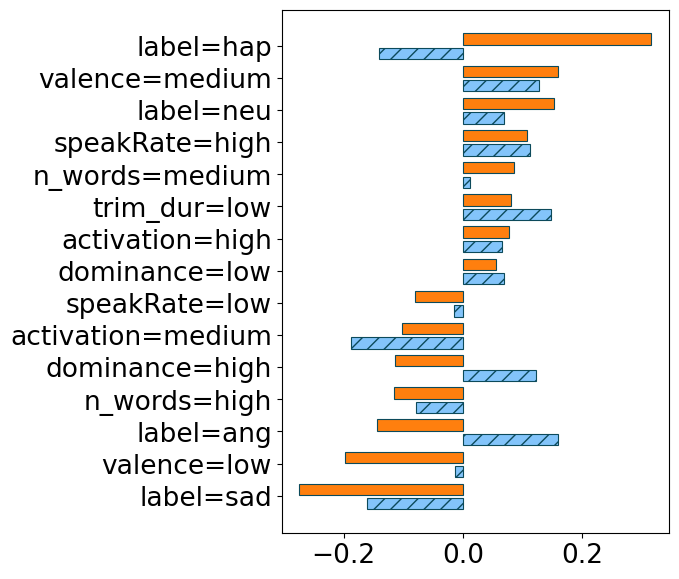

In [103]:
## Take the K Global Shapley Values for HubB-WavB starting from the top-K of WavL-WavB
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)
topK_global_w2b_hb_1_abbr = {k:v*100 for k,v in topK_global_w2b_hb_1_abbr.items()}
                        
name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2b_w2l_w2b_hb_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2b_w2l_w2b_hb_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2b_w2l_abbr, 
            shapley_values_2=topK_global_w2b_hb_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

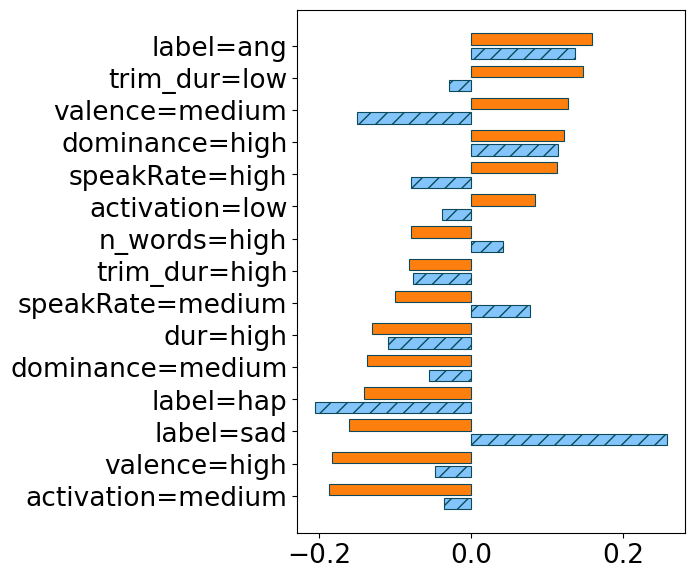

In [104]:
## Take the K Global Shapley Values for WavL-HubL starting from the top-K of WavB-HubB
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)
topK_global_w2l_hl_1_abbr = {k:v*100 for k,v in topK_global_w2l_hl_1_abbr.items()}

name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2b_hb_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2b_hb_w2l_hl_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2b_hb_abbr, 
            shapley_values_2=topK_global_w2l_hl_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

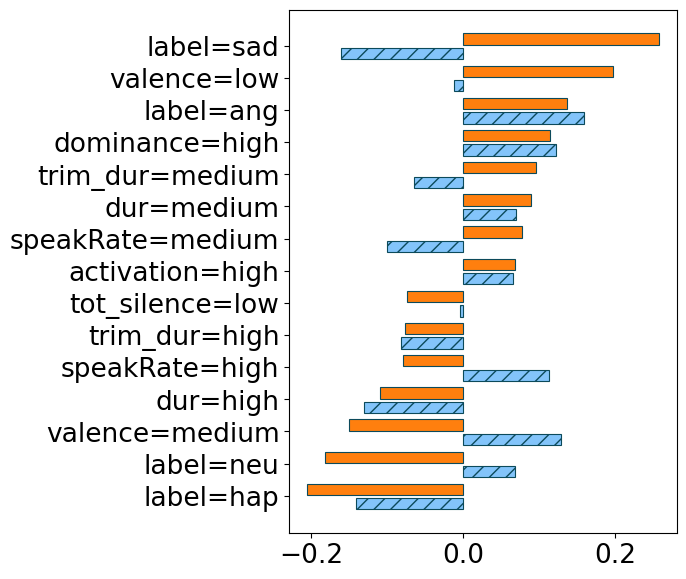

In [105]:
## Take the K Global Shapley Values for WavB-HubB starting from the top-K of WavL-HubL
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2l_hl)}, abbreviations)
topK_global_w2b_hb_1_abbr = {k:v*100 for k,v in topK_global_w2b_hb_1_abbr.items()}

name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2l_hl_w2b_hb_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2l_hl_w2b_hb_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2l_hl_abbr, 
            shapley_values_2=topK_global_w2b_hb_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

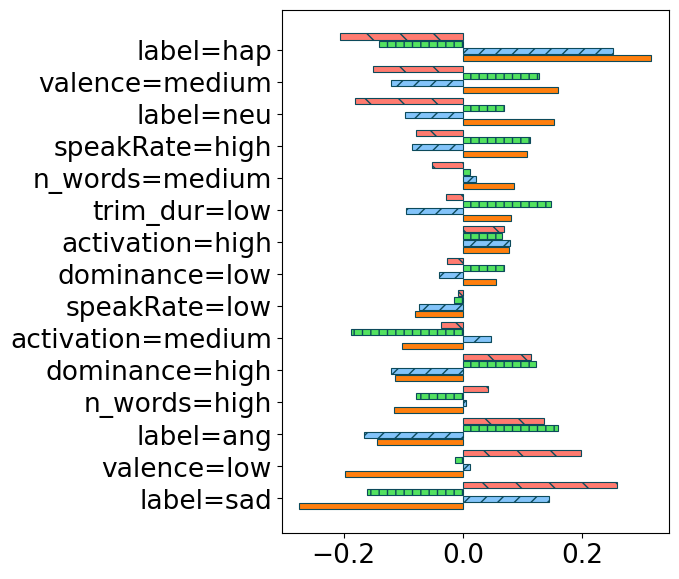

In [106]:
## Take the K Global Shapley Values for HubB-HubL starting from the top-K of WavB-WavL
topK_global_hb_hl_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)
topK_global_hb_hl_1_abbr = {k:v*100 for k,v in topK_global_hb_hl_1_abbr.items()}

## Take the K Global Shapley Values for Wav2B-HubB starting from the top-K of WavB-WavL
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)
topK_global_w2b_hb_1_abbr = {k:v*100 for k,v in topK_global_w2b_hb_1_abbr.items()}

## Take the K Global Shapley Values for Wav2L-HubL starting from the top-K of WavB-WavL
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)
topK_global_w2l_hl_1_abbr = {k:v*100 for k,v in topK_global_w2l_hl_1_abbr.items()}

name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2b_w2l_hb_hl_w2b_hb_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2b_w2l_hb_hl_w2b_hb_w2l_hl_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_abbr, 
                shapley_values_2=topK_global_hb_hl_1_abbr,
                shapley_values_3=topK_global_w2b_hb_1_abbr,
                shapley_values_4=topK_global_w2l_hl_1_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)

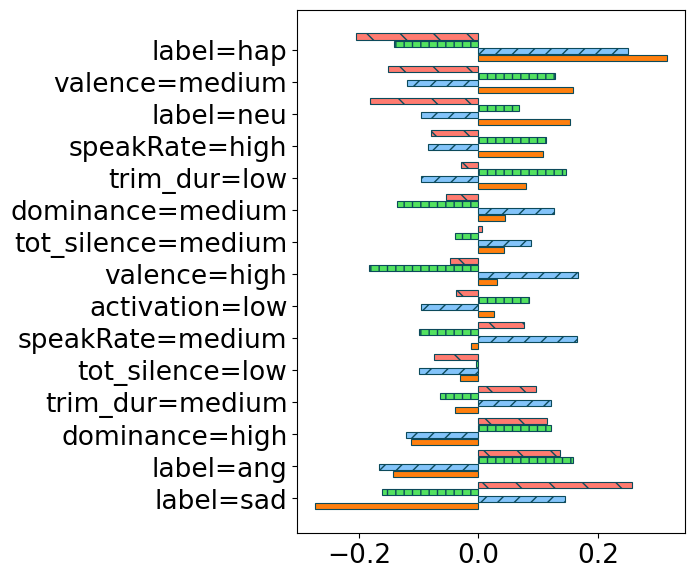

In [107]:
## Take the K Global Shapley Values for Wav2B-Wav2L starting from the top-K of HubB-HubL
topK_global_w2b_w2l_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(topK_global_hb_hl)}, abbreviations)
topK_global_w2b_w2l_1_abbr = {k:v*100 for k,v in topK_global_w2b_w2l_1_abbr.items()}

## Take the K Global Shapley Values for Wav2B-HubB starting from the top-K of HubB-HubL
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_hb_hl)}, abbreviations)
topK_global_w2b_hb_1_abbr = {k:v*100 for k,v in topK_global_w2b_hb_1_abbr.items()}

## Take the K Global Shapley Values for Wav2L-HubL starting from the top-K of HubB-HubL
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_hb_hl)}, abbreviations)
topK_global_w2l_hl_1_abbr = {k:v*100 for k,v in topK_global_w2l_hl_1_abbr.items()}

name_fig = f"plot_results/IEMOCAP/global_shapley_gain_hb_hl_w2b_w2l_w2b_hb_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/IEMOCAP/global_shapley_gain_hb_hl_w2b_w2l_w2b_hb_w2l_hl_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_1_abbr, 
                shapley_values_2=topK_global_hb_hl_abbr,
                shapley_values_3=topK_global_w2b_hb_1_abbr,
                shapley_values_4=topK_global_w2l_hl_1_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)

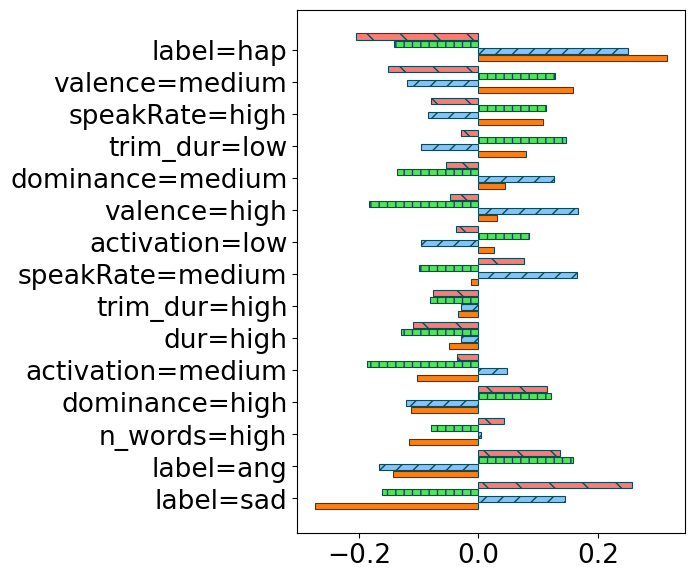

In [108]:
## Take the K Global Shapley Values for Wav2B-Wav2L starting from the top-K of Wav2B-HubB
topK_global_w2b_w2l_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)
topK_global_w2b_w2l_1_abbr = {k:v*100 for k,v in topK_global_w2b_w2l_1_abbr.items()}

## Take the K Global Shapley Values for HubB-HubL starting from the top-K of Wav2B-HubB
topK_global_hb_hl_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)
topK_global_hb_hl_1_abbr = {k:v*100 for k,v in topK_global_hb_hl_1_abbr.items()}

## Take the K Global Shapley Values for Wav2L-HubL starting from the top-K of Wav2B-HubB
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)
topK_global_w2l_hl_1_abbr = {k:v*100 for k,v in topK_global_w2l_hl_1_abbr.items()}

name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2b_hb_w2b_w2l_hb_hl_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2b_hb_w2b_w2l_hb_hl_w2l_hl_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_1_abbr, 
                shapley_values_2=topK_global_hb_hl_1_abbr,
                shapley_values_3=topK_global_w2b_hb_abbr,
                shapley_values_4=topK_global_w2l_hl_1_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)

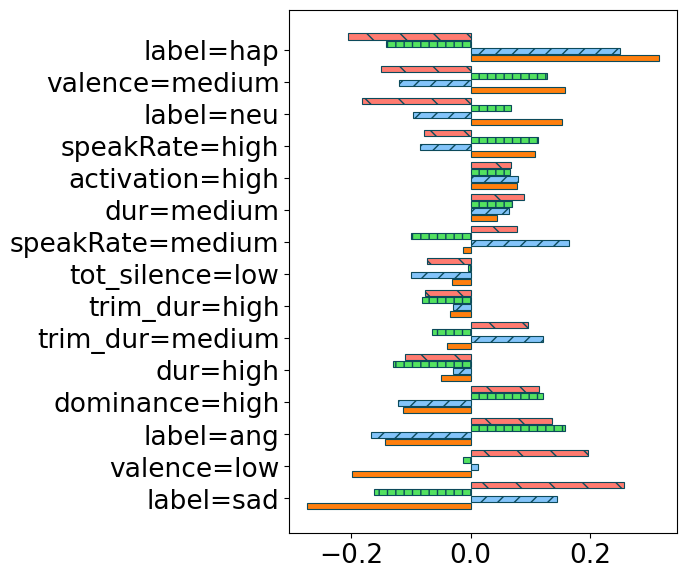

In [109]:
## Take the K Global Shapley Values for Wav2B-Wav2L starting from the top-K of Wav2L-HubL
topK_global_w2b_w2l_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(topK_global_w2l_hl)}, abbreviations)
topK_global_w2b_w2l_1_abbr = {k:v*100 for k,v in topK_global_w2b_w2l_1_abbr.items()}

## Take the K Global Shapley Values for HubB-HubL starting from the top-K of Wav2L-HubL
topK_global_hb_hl_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2l_hl)}, abbreviations)
topK_global_hb_hl_1_abbr = {k:v*100 for k,v in topK_global_hb_hl_1_abbr.items()}

## Take the K Global Shapley Values for Wav2B-HubB starting from the top-K of Wav2L-HubL
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2l_hl)}, abbreviations)
topK_global_w2b_hb_1_abbr = {k:v*100 for k,v in topK_global_w2b_hb_1_abbr.items()}

name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2l_hl_w2b_w2l_hb_hl_w2b_hb_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/IEMOCAP/global_shapley_gain_w2l_hl_w2b_w2l_hb_hl_w2b_hb_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_1_abbr, 
                shapley_values_2=topK_global_hb_hl_1_abbr,
                shapley_values_3=topK_global_w2b_hb_1_abbr,
                shapley_values_4=topK_global_w2l_hl_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)